# Basic Testing

## Import Libraries, include General UNET Wrapper

In [12]:
from UNETPyTorch.V1.UnetModel import GeneralUNETModel

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Create the Softmax Output Layer

This layer will take the anticipated (B, conv_channels, H, W) tensor, convolution it once more, and pool the two dimensions into a (1, 1) size. The last convolution will drop the channel size to the desired number of output classes.

In [2]:
# Create the output layer
class PoolSoftmaxOutput(nn.Module):
    def __init__(self, in_channels, out_classes):
        super().__init__()
        # 1x1 Convolution to go from UNET channels to MNIST classes
        self.final_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_classes, kernel_size=1)

    def forward(self, unet_output):
        conv_output = self.final_conv(unet_output)

        # Global average pooling
        pooled_output = F.adaptive_avg_pool2d(conv_output, (1, 1))

        # Flatten down to 1 dimension
        class_output = pooled_output.view(pooled_output.size(0), -1)

        # Return the raw values of each class
        return class_output

## Import the MNIST Numbers Data

In [3]:
# Specify normalization transformation for data
IMG_SIZE = 64
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resizes to a power of two for simple handling
    transforms.ToTensor(),  # Converts images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images (mean, std)
])

# Load MNIST dataset (training and test sets)
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader to load data in batches
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

next(iter(test_loader))

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         ...,
 
 
         [[[-1., -1., -1.,  ..., -

## Show an Example Image

Text(0.5, 1.0, 'Label: 5')

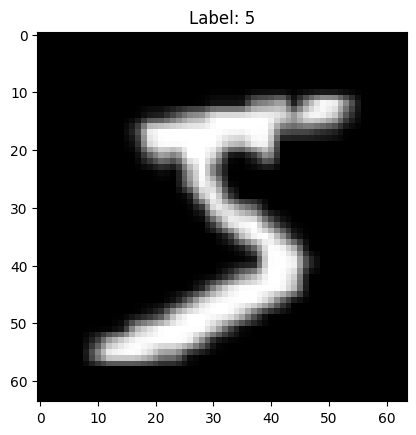

In [4]:
# Visualize a sample image to ensure it's loaded correctly
first_image, first_label = train_dataset[0]
plt.imshow(first_image.squeeze(), cmap='gray')  # MNIST is single-channel, using cmap='gray'
plt.title(f"Label: {first_label}")


## Create and Train the Model

In [5]:
# Create the model to use
dimensions = 2
channels = 1
conv_filters = [64, 128, 256, 512]
mnist_classes = 10
my_out_layer = PoolSoftmaxOutput(in_channels=conv_filters[0], out_classes=mnist_classes)
optim_loss_rate = 0.002
mnist_model = GeneralUNETModel(
    name='unet_attention_mnist_model', in_dimensions=dimensions, in_channels=channels, conv_channels=conv_filters,
    out_layer=my_out_layer, use_up_atten=True, use_attn_pool=True, loss_rate=optim_loss_rate
)

In [6]:
# Train the model
epoch_count = 1
print_count = 100
print_interval = max(1, len(train_loader) // print_count)
loss_module = nn.CrossEntropyLoss()
model_train_stats = mnist_model.train_model(
    train_loader=train_loader, epochs=epoch_count, loss_func=loss_module, print_interval=print_interval
)
print(model_train_stats)

Cuda availability status: True
New best loss score: 2.289834976196289
Saving epoch model...
New best loss score: 2.254906415939331
Saving epoch model...
New best loss score: 2.201108455657959
Saving epoch model...
New best loss score: 2.071263074874878
Saving epoch model...
New best loss score: 2.0016705989837646
Saving epoch model...
New best loss score: 1.8525292873382568
Saving epoch model...
Epoch: 1, Batch: 18, Loss: 1.7412
New best loss score: 1.7412073612213135
Saving epoch model...
New best loss score: 1.7279571294784546
Saving epoch model...
New best loss score: 1.6857398748397827
Saving epoch model...
New best loss score: 1.602891206741333
Saving epoch model...
New best loss score: 1.5397121906280518
Saving epoch model...
New best loss score: 1.5175145864486694
Saving epoch model...
Epoch: 1, Batch: 36, Loss: 1.5862
New best loss score: 1.453007698059082
Saving epoch model...
Epoch: 1, Batch: 54, Loss: 1.3380
New best loss score: 1.3380241394042969
Saving epoch model...
New b

## Test the Model

In [7]:
# Test the model
loss_module = nn.CrossEntropyLoss()
mnist_model.test_model(test_loader=test_loader, loss_func=loss_module)

Cuda availability status: True
Batch: 1
Predictions:    tensor([7, 2, 1, 0, 4, 1, 8, 9, 8, 9, 0, 6, 9, 0, 1, 5, 9, 7, 5, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1], device='cuda:0')
Labels:         tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1], device='cuda:0')
Loss:           0.2000

Batch: 2
Predictions:    tensor([3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0,
        4, 1, 9, 5, 7, 8, 9, 3], device='cuda:0')
Labels:         tensor([3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0,
        4, 1, 9, 5, 7, 8, 9, 3], device='cuda:0')
Loss:           0.0255

Batch: 3
Predictions:    tensor([7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 8, 7, 7, 6, 2, 7, 8, 4, 7, 3,
        6, 1, 3, 6, 8, 3, 1, 4], device='cuda:0')
Labels:         tensor([7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
        6, 1, 3, 6, 9, 3, 1, 4], device='cuda:0')
Loss:           0.

0.09581127132738408

# Testing Options

In [8]:
# Create Various Models
dimensions = 2
channels = 1
conv_filters = [64, 128, 256, 512]
mnist_classes = 10
my_out_layer = PoolSoftmaxOutput(in_channels=conv_filters[0], out_classes=mnist_classes)
optim_loss_rate = 0.002
mnist_basic_model = GeneralUNETModel(
    name='mnist_basic_model', in_dimensions=dimensions, in_channels=channels, conv_channels=conv_filters,
    out_layer=my_out_layer, up_drop_perc=0.0
)
mnist_dropout_model = GeneralUNETModel(
    name='mnist_dropout_model', in_dimensions=dimensions, in_channels=channels, conv_channels=conv_filters,
    out_layer=my_out_layer
)
mnist_attention_model = GeneralUNETModel(
    name='mnist_attention_model', in_dimensions=dimensions, in_channels=channels, conv_channels=conv_filters,
    out_layer=my_out_layer, use_up_atten=True
)
mnist_attention_pooling_model = GeneralUNETModel(
    name='mnist_attn_pool_model', in_dimensions=dimensions, in_channels=channels, conv_channels=conv_filters,
    out_layer=my_out_layer, use_up_atten=True, use_attn_pool=True
)

In [9]:
# Train and then test each model
epoch_count = 1
print_count = 100
print_interval = max(1, len(train_loader) // print_count)
loss_module = nn.CrossEntropyLoss()
models = [mnist_basic_model, mnist_dropout_model, mnist_attention_model, mnist_attention_pooling_model]
model_names = [
    mnist_basic_model.model_name, mnist_dropout_model.model_name, mnist_attention_model.model_name, 
    mnist_attention_pooling_model.model_name
]
model_test_scores = []
for model in models:
    model.train_model(
        train_loader=train_loader, epochs=epoch_count, loss_func=loss_module, print_interval=print_interval
    )
    model_test_avg = model.test_model(test_loader=test_loader, loss_func=loss_module)
    model_test_scores.append(model_test_avg)

for model_name, score in zip(model_names, model_test_scores):
    print(f"{model_name}'s average test score: {score}")

Cuda availability status: True
New best loss score: 2.3168210983276367
Saving epoch model...
New best loss score: 2.2958216667175293
Saving epoch model...
New best loss score: 2.2554197311401367
Saving epoch model...
New best loss score: 2.181891918182373
Saving epoch model...
New best loss score: 2.0577304363250732
Saving epoch model...
New best loss score: 2.042898654937744
Saving epoch model...
New best loss score: 1.9347565174102783
Saving epoch model...
New best loss score: 1.8252110481262207
Saving epoch model...
New best loss score: 1.765647292137146
Saving epoch model...
Epoch: 1, Batch: 18, Loss: 2.2699
New best loss score: 1.7046995162963867
Saving epoch model...
New best loss score: 1.6739205121994019
Saving epoch model...
Epoch: 1, Batch: 36, Loss: 1.6286
New best loss score: 1.6286203861236572
Saving epoch model...
New best loss score: 1.5441327095031738
Saving epoch model...
New best loss score: 1.5177618265151978
Saving epoch model...
New best loss score: 1.5093277692794

# Test Various Conv Filters

In [10]:
# Create Various Models
dimensions = 2
channels = 1
conv_filters = [64, 128, 256, 512]
mnist_classes = 10
my_out_layer = PoolSoftmaxOutput(in_channels=conv_filters[0], out_classes=mnist_classes)
optim_loss_rate = 0.002
mnist_dropout_three_model = GeneralUNETModel(
    name='mnist_dropout_three_model', in_dimensions=dimensions, in_channels=channels, conv_channels=[64, 128, 256],
    out_layer=my_out_layer
)
mnist_dropout_five_model = GeneralUNETModel(
    name='mnist_dropout_five_model', in_dimensions=dimensions, in_channels=channels, 
    conv_channels=[64, 128, 256, 512, 1024], out_layer=my_out_layer
)

models = [mnist_dropout_model, mnist_dropout_three_model, mnist_dropout_five_model]
model_names = [
    mnist_dropout_model.model_name, mnist_dropout_three_model.model_name, 
    mnist_dropout_five_model.model_name
]
model_test_scores = [model_test_scores[1]]
for model in [mnist_dropout_three_model, mnist_dropout_five_model]:
    model.train_model(
        train_loader=train_loader, epochs=epoch_count, loss_func=loss_module, print_interval=print_interval
    )
    model_test_avg = model.test_model(test_loader=test_loader, loss_func=loss_module)
    model_test_scores.append(model_test_avg)

for model_name, score in zip(model_names, model_test_scores):
    print(f"{model_name}'s average test score: {score}")

Cuda availability status: True
New best loss score: 2.329420804977417
Saving epoch model...
New best loss score: 2.2609169483184814
Saving epoch model...
New best loss score: 2.2257003784179688
Saving epoch model...
New best loss score: 2.2108571529388428
Saving epoch model...
New best loss score: 2.1718125343322754
Saving epoch model...
New best loss score: 2.135308265686035
Saving epoch model...
New best loss score: 2.075894355773926
Saving epoch model...
New best loss score: 2.0274534225463867
Saving epoch model...
New best loss score: 1.9036893844604492
Saving epoch model...
New best loss score: 1.8917052745819092
Saving epoch model...
Epoch: 1, Batch: 18, Loss: 1.9207
New best loss score: 1.6585782766342163
Saving epoch model...
New best loss score: 1.5996949672698975
Saving epoch model...
New best loss score: 1.5880972146987915
Saving epoch model...
Epoch: 1, Batch: 36, Loss: 1.6700
New best loss score: 1.4879100322723389
Saving epoch model...
New best loss score: 1.4175951480865

# Adjust Double Convolution Activation Function

In [14]:
# Create Swiss activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Create Various Models
dimensions = 2
channels = 1
conv_filters = [64, 128, 256]
mnist_classes = 10
my_out_layer = PoolSoftmaxOutput(in_channels=conv_filters[0], out_classes=mnist_classes)
optim_loss_rate = 0.002
mnist_dropout_three_gelu_model = GeneralUNETModel(
    name='mnist_dropout_three_gelu_model', in_dimensions=dimensions, in_channels=channels, conv_channels=[64, 128, 256],
    out_layer=my_out_layer, dconv_act_fn=nn.GELU()
)
mnist_dropout_three_swiss_model = GeneralUNETModel(
    name='mnist_dropout_three_swiss_model', in_dimensions=dimensions, in_channels=channels, conv_channels=[64, 128, 256],
    out_layer=my_out_layer, dconv_act_fn=Swish()
)

models = [mnist_dropout_three_model, mnist_dropout_three_gelu_model, mnist_dropout_three_swiss_model]
model_names = [
    mnist_dropout_three_model.model_name, mnist_dropout_three_gelu_model.model_name, 
    mnist_dropout_three_swiss_model.model_name
]
model_test_scores = [model_test_scores[1]]
for model in [mnist_dropout_three_gelu_model, mnist_dropout_three_swiss_model]:
    model.train_model(
        train_loader=train_loader, epochs=epoch_count, loss_func=loss_module, print_interval=print_interval
    )
    model_test_avg = model.test_model(test_loader=test_loader, loss_func=loss_module)
    model_test_scores.append(model_test_avg)

for model_name, score in zip(model_names, model_test_scores):
    print(f"{model_name}'s average test score: {score}")

mnist_dropout_three_model's average test score: 0.07619644060341148
mnist_dropout_three_model's average test score: 0.06958235440252813
mnist_dropout_three_model's average test score: 0.052679342424166734


# Test Using Double Convolution Residuals

In [15]:
# Create Various Models
dimensions = 2
channels = 1
conv_filters = [64, 128, 256]
mnist_classes = 10
my_out_layer = PoolSoftmaxOutput(in_channels=conv_filters[0], out_classes=mnist_classes)
optim_loss_rate = 0.002
mnist_dropout_three_swiss_model = GeneralUNETModel(
    name='mnist_dropout_three_swiss_model', in_dimensions=dimensions, in_channels=channels, conv_channels=[64, 128, 256],
    out_layer=my_out_layer, dconv_act_fn=Swish()
)
mnist_dropout_three_swiss_res_model = GeneralUNETModel(
    name='mnist_dropout_three_swiss_res_model', in_dimensions=dimensions, in_channels=channels, conv_channels=[64, 128, 256],
    out_layer=my_out_layer, dconv_act_fn=Swish(), use_dconv_res=True
)

models = [mnist_dropout_three_swiss_model, mnist_dropout_three_swiss_res_model]
model_names = [
    mnist_dropout_three_swiss_model.model_name,
    mnist_dropout_three_swiss_res_model.model_name
]
model_test_scores = []
for model in models:
    model.train_model(
        train_loader=train_loader, epochs=epoch_count, loss_func=loss_module, print_interval=print_interval
    )
    model_test_avg = model.test_model(test_loader=test_loader, loss_func=loss_module)
    model_test_scores.append(model_test_avg)

for model_name, score in zip(model_names, model_test_scores):
    print(f"{model_name}'s average test score: {score}")

Cuda availability status: True
New best loss score: 2.2973122596740723
Saving epoch model...
New best loss score: 2.284602642059326
Saving epoch model...
New best loss score: 2.227235794067383
Saving epoch model...
New best loss score: 2.1748199462890625
Saving epoch model...
New best loss score: 2.140169382095337
Saving epoch model...
New best loss score: 2.117464780807495
Saving epoch model...
New best loss score: 1.9698951244354248
Saving epoch model...
New best loss score: 1.84723699092865
Saving epoch model...
Epoch: 1, Batch: 18, Loss: 1.9423
New best loss score: 1.7307318449020386
Saving epoch model...
New best loss score: 1.698778510093689
Saving epoch model...
New best loss score: 1.6836183071136475
Saving epoch model...
New best loss score: 1.6583999395370483
Saving epoch model...
New best loss score: 1.4949314594268799
Saving epoch model...
Epoch: 1, Batch: 36, Loss: 1.4175
New best loss score: 1.4174630641937256
Saving epoch model...
New best loss score: 1.4174572229385376
